In [1]:
# import modules

import requests
import json
import zipfile
import io
import pydicom
from pydicom import dcmread
from pydicom.filebase import DicomBytesIO
import matplotlib.pyplot as plt
%matplotlib inline

**The Cancer Imaging Archive (TCIA) is a service which de-identifies and hosts a large archive of medical images of cancer accessible for public download. The data are organized as “collections”; typically patients’ imaging related by a common disease (e.g. lung cancer), image modality or type (MRI, CT, digital histopathology, etc) or research focus. DICOM is the primary file format used by TCIA for radiology imaging. Supporting data related to the images such as patient outcomes, treatment details, genomics and expert analyses are also provided when available.**

*Here, we have provided a series of methods to make requests to the TCIA API and download medical images of cancer available in their archive*

# Get Collections 
The method getCollections helps us to store all the publicly available collections of dataset.

In [2]:
def getCollections():
    '''Provides all the collections available in the Archive'''
    baseurl = 'https://services.cancerimagingarchive.net/services/v3/TCIA'
    queryEndpoint = '/query/getCollectionValues?'
    queryParams = ''
    form = 'format=json'
    url = baseurl+queryEndpoint+queryParams+form
    
    response = requests.get(url)
    if response.status_code==200:
        Collections = []
        for dictionary in response.json():
            Collections.append(dictionary['Collection'])
        return Collections
    else:
        raise ValueError('Bad/No response')

AllCollections = getCollections()

Next, we would like to see the body part location corresponding to the collection dataset.

# Get the body part corresponding to each collection

In [6]:
def getBodyPart(Collection):
    '''Provides the body part affected in a collection dataset'''
    baseurl = 'https://services.cancerimagingarchive.net/services/v3/TCIA'
    queryEndpoint = '/query/getBodyPartValues?'
    queryParams = f'Collection={Collection}&'
    form = 'format=json'
    url = baseurl+queryEndpoint+queryParams+form
    response = requests.get(url)
    if response.status_code==200:
        BodyPartExamined = []
        for dictionary in response.json():
            try:
                BodyPartExamined.append(dictionary['BodyPartExamined']) 
            except:
                continue
        return BodyPartExamined
    else:
        raise ValueError('Bad/No response')  

Create a dictionary of collection name and the part of the body affected 

In [7]:
BodyPartAffected = {}

for collection in AllCollections:
    print(collection)
    BodyPartAffected[collection] = getBodyPart(collection)

TCGA-GBM
LIDC-IDRI
BREAST-DIAGNOSIS
PROSTATE-MRI
PROSTATE-DIAGNOSIS
NaF PROSTATE
CT COLONOGRAPHY
REMBRANDT
RIDER Breast MRI
RIDER Lung CT
RIDER NEURO MRI
RIDER PHANTOM MRI
RIDER PHANTOM PET-CT
RIDER Lung PET-CT
QIBA CT-1C
Phantom FDA
TCGA-BRCA
TCGA-LGG
TCGA-KIRC
TCGA-LUAD
Prostate-3T
QIN-HEADNECK
TCGA-PRAD
NSCLC Radiogenomics
Head-Neck Cetuximab
TCGA-LIHC
TCGA-KIRP
TCGA-OV
TCGA-HNSC
TCGA-KICH
TCGA-BLCA
TCGA-LUSC
TCGA-COAD
TCGA-THCA
TCGA-READ
NSCLC-Radiomics-Genomics
QIN DCE-MRI Challenge
Lung Phantom
NSCLC-Radiomics
QIN Breast DCE-MRI
QIN PET Phantom
ISPY1
TCGA-UCEC
SPIE-AAPM Lung CT Challenge
TCGA-ESCA
TCGA-STAD
TCGA-CESC
QIN LUNG CT
TCGA-SARC
LungCT-Diagnosis
CT Lymph Nodes
Mouse-Astrocytoma
Mouse-Mammary
Prostate Fused-MRI-Pathology
QIN-BRAIN-DSC-MRI
Soft-tissue-Sarcoma
4D-Lung
Breast-MRI-NACT-Pilot
Pancreas-CT
CBIS-DDSM
PROSTATEx
HNSCC
IvyGAP
Head-Neck-PET-CT
LCTSC
LGG-1p19qDeletion
CC-Radiomics-Phantom
ACRIN-FLT-Breast
CPTAC-PDA
CPTAC-UCEC
CPTAC-CCRCC
CPTAC-LUAD
CPTAC-GBM
CPTAC-LS

# Only Brain and Lungs collection

Among the body part affected dictionary, filter out only those collections which have just one place affected and it must either be the brain or the lung.

In [8]:
def filter_collections():
    '''returns only those collections where the body part affected is
    either the brain or the lung'''
    Collections_brain = []
    Collections_lung  = []
    for key,value in BodyPartAffected.items():
        if len(value)==1:
            if value[0] == 'BRAIN':
                Collections_brain.append(key)
            elif value[0] == 'LUNG':
                Collections_lung.append(key)
    return Collections_brain,Collections_lung

brain,lungs = filter_collections()

In [9]:
brain

['TCGA-GBM',
 'REMBRANDT',
 'RIDER NEURO MRI',
 'TCGA-LGG',
 'QIN-BRAIN-DSC-MRI',
 'LGG-1p19qDeletion',
 'Brain-Tumor-Progression',
 'ACRIN-FMISO-Brain']

In [10]:
lungs

['TCGA-LUSC',
 'NSCLC-Radiomics-Genomics',
 'SPIE-AAPM Lung CT Challenge',
 'LungCT-Diagnosis',
 '4D-Lung',
 'LCTSC',
 'NSCLC-RADIOMICS-INTEROBSERVER1']

# Get series ids values

Now that we have selected the collections, we will try to get the series ids of the data in each of these collections. The series ids can later be used to query the images

In [30]:
def getSeriesID(Collection):
    baseurl = 'https://services.cancerimagingarchive.net/services/v3/TCIA'
    queryEndpoint = '/query/getSeries?'
    queryParams = f'Collection={Collection}&'
    form = 'format=json'
    url = baseurl+queryEndpoint+queryParams+form
    response = requests.get(url)
    SeriesInstanceUID = []
    for dictionary in response.json():
        SeriesInstanceUID.append(dictionary['SeriesInstanceUID'])
    return SeriesInstanceUID
        
    
SeriesIDS = getSeriesID(brain[3])
   

In [26]:
SeriesIDS[:5]

['1.3.6.1.4.1.14519.5.2.1.1188.4001.414230446273144753102580987157',
 '1.3.6.1.4.1.14519.5.2.1.1188.4001.132691411436475486878420509309',
 '1.3.6.1.4.1.14519.5.2.1.1188.4001.724227449850990988403354297278',
 '1.3.6.1.4.1.14519.5.2.1.1188.4001.106168498915887899086476068294',
 '1.3.6.1.4.1.14519.5.2.1.1188.4001.311513693456544543531535133857']

# Get Image by Series ID

In [31]:
def download_extract_zip(url):
    """
    Download a ZIP file and extract its contents in raw bytes format 
    in memory
    yields (filename, file-like object) pairs
    """
    response = requests.get(url)
    with zipfile.ZipFile(io.BytesIO(response.content)) as thezip:
        for zipinfo in thezip.infolist():
            data = thezip.read(zipinfo.filename)
            yield zipinfo.filename, data

def getImage(SeriesID):
    '''Gets the images for a series IDfrom the api and returns it 
    as a DICOM object'''
    baseurl = 'https://services.cancerimagingarchive.net/services/v3/TCIA'
    queryEndpoint = '/query/getImage?'
    queryParams = f'SeriesInstanceUID={SeriesID}&'
    form = 'format=zip'
    url = baseurl+queryEndpoint+queryParams+form
    files = []
    for i,j in download_extract_zip(url):
        files.append((i,j))
    ds = []
    for file in files:
        if file[1]:
            ds.append(dcmread(DicomBytesIO(file[1])))
    return ds

In [32]:
AllImages = getImage(SeriesIDS[0])

C:\Users\deeprob\AppData\Roaming\Python\Python36\site-packages\pydicom\filereader.py:313: UserWarning: Expected explicit VR, but found implicit VR - using implicit VR for reading
  warnings.warn(message, UserWarning)


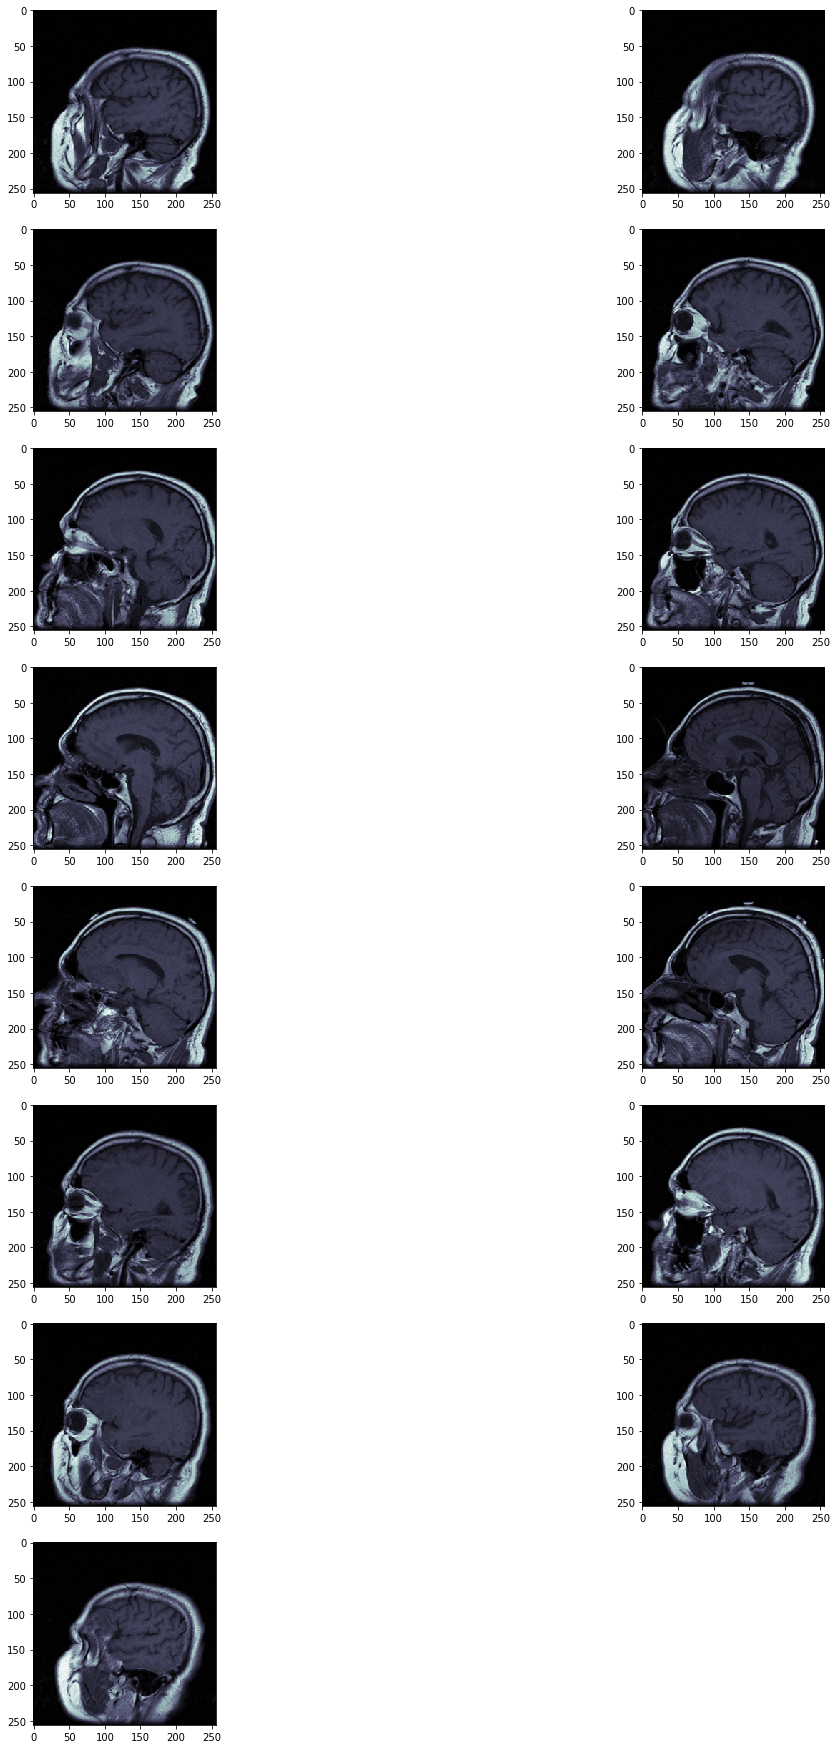

In [33]:
plt.figure(figsize=(20,100))
for i,j in enumerate(AllImages):
    if i==50:
        break
    plt.subplot(25,2,i+1)
    plt.imshow(j.pixel_array, cmap=plt.cm.bone)
        